Original Image Shape: torch.Size([3, 1365, 2048])


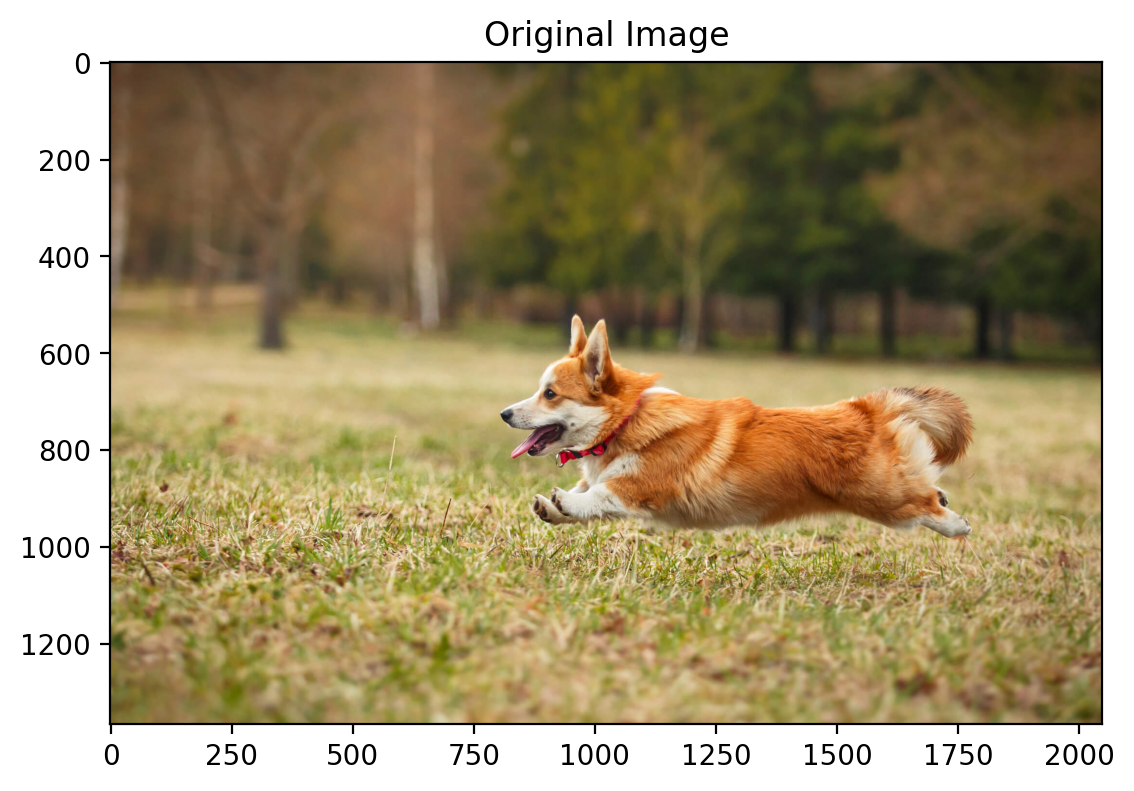

Image shape: torch.Size([3, 1365, 2048])
Image cropped shape: torch.Size([3, 400, 400])


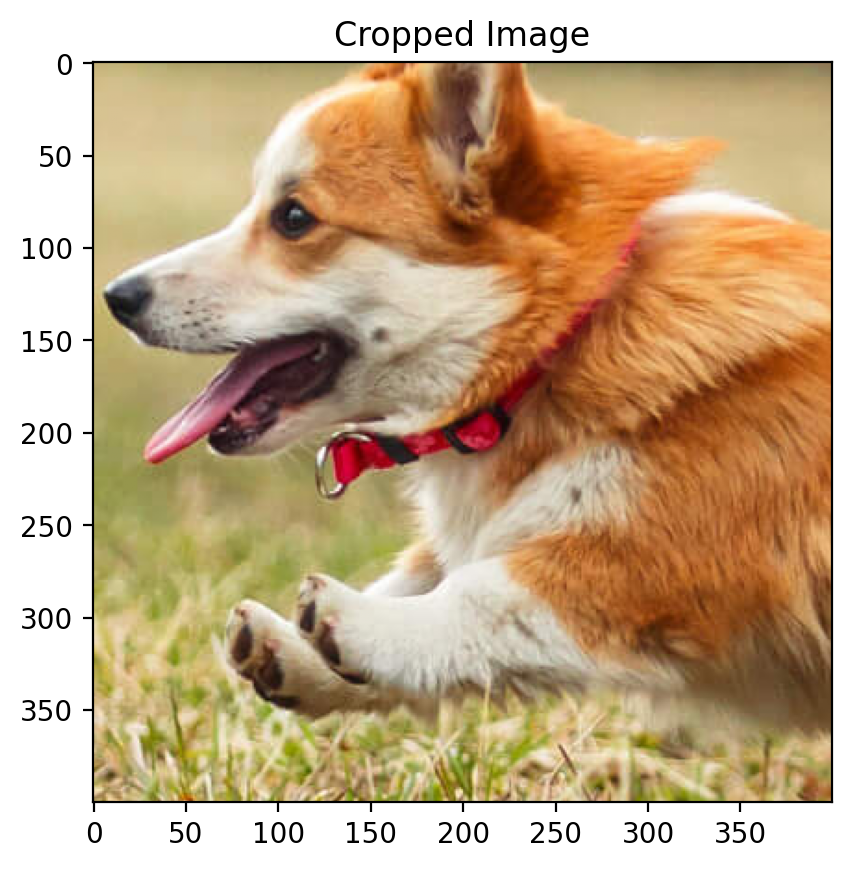

Image cropped shape: torch.Size([3, 400, 400])


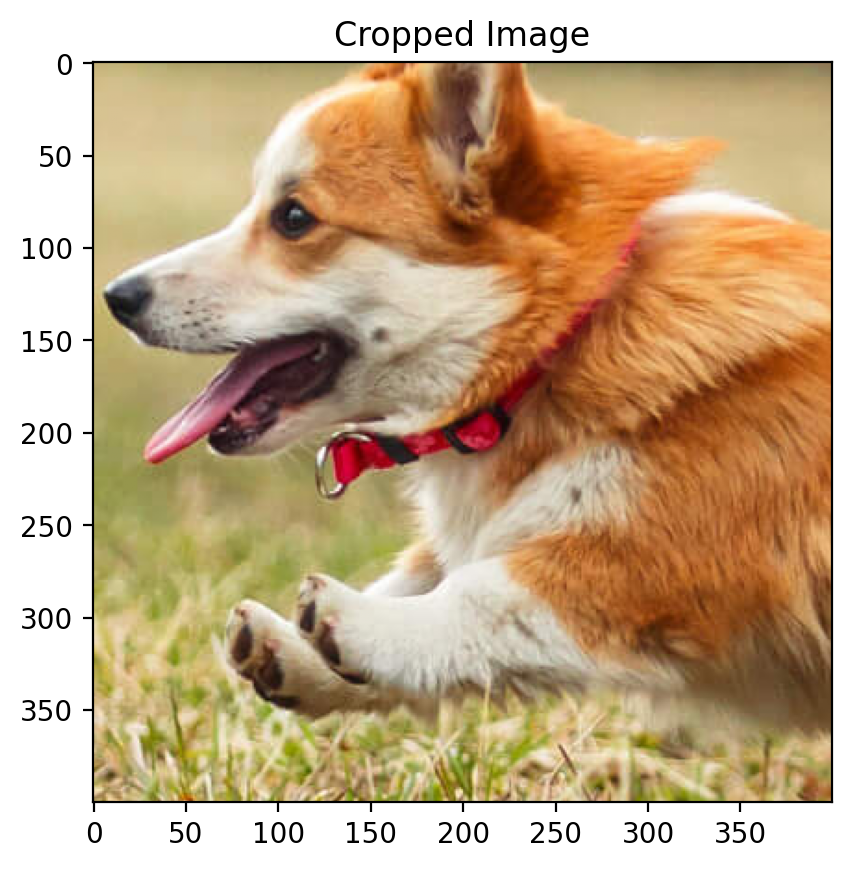

In [2]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import preprocessing
from sklearn.kernel_approximation import RBFSampler
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

def plot_compare_images(img1, img2, title1='Image 1', title2='Image 2'):
    """
    Plots a comparison between two images in a subplot.
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))

    ax[0].imshow(rearrange(img1, 'c h w -> h w c').numpy())
    ax[0].set_title(title1)
    ax[0].axis('off')

    ax[1].imshow(rearrange(img2, 'c h w -> h w c').numpy())
    ax[1].set_title(title2)
    ax[1].axis('off')

    plt.show()



def plot_compare_images_with_missing_data(percentage, img1, img2, img3, title1='Image 1', title2='Image 2', title3='Image 3'):
    """
    Plots a comparison between two images in a subplot.
    """
    fig, ax = plt.subplots(1, 3, figsize=(20, 7))

    ax[0].imshow(rearrange(img1, 'c h w -> h w c').numpy())
    ax[0].set_title(title1)
    ax[0].axis('off')

    ax[1].imshow(rearrange(img2, 'c h w -> h w c').numpy())
    ax[1].set_title(title2)
    ax[1].axis('off')

    ax[2].imshow(rearrange(img3, 'c h w -> h w c').numpy())
    ax[2].set_title(title3)
    ax[2].axis('off')

    plt.suptitle(f"Percentage of missing data: {percentage}%")
    plt.show()



def create_coordinate_map(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    scale: int, the scale factor for the image

    return: tuple of torch.Tensor of shape (height * width * scale**2, 2) and torch.Tensor of shape (height * width * scale**2, num_channels)
    """

    num_channels, height, width = img.shape

    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float()
    Y = torch.tensor(rearrange(img, 'c h w -> (h w) c').float())
    X = X.to(device)
    Y = Y.to(device)
    return X, Y

def RFF_transform(X, n_components, sigma=0.008):

    X_flat = rearrange(X, 'c h w -> (h w) c').cpu().numpy()
    RFF = RBFSampler(n_components=n_components, gamma=1/(2 * sigma**2))
    X_transformed = RFF.fit_transform(X_flat)

    from sklearn.linear_model import LinearRegression
    linear_regressor = LinearRegression()
    linear_regressor.fit(X_transformed, X_flat)
    X_reconstructed = linear_regressor.predict(X_transformed)

    X_reconstructed = X_reconstructed.reshape(X.shape[1], X.shape[2], 3).transpose(2, 0, 1)
    return torch.tensor(X_reconstructed, dtype=torch.float32).to(device)  # Convert back to tensor



def SNR(image1, image2):
    """
    Compute the Signal-to-Noise Ratio (SNR) between two images.
    """
    image1 = torch.tensor(image1, dtype=torch.float32)
    image2 = torch.tensor(image2, dtype=torch.float32)
    signal = image1
    noise = image1 - image2
    signal_power = torch.sum(signal ** 2)
    noise_power = torch.sum(noise ** 2)
    snr = 10 * torch.log10(signal_power / noise_power)
    return snr.item()


img = torchvision.io.read_image("dog.jpg")
print(f"Original Image Shape: {img.shape}")
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())
plt.title('Original Image')
plt.show()

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = torch.tensor(scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape))
img_scaled = img_scaled.to(device)
print(f'Image shape: {img_scaled.shape}')

img_cropped = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 400, 400)
img_cropped = img_cropped.to(device)
print(f'Image cropped shape: {img_cropped.shape}')
plt.imshow(rearrange(img_cropped, 'c h w -> h w c').cpu().numpy())
plt.title('Cropped Image')
plt.show()

import torch
from sklearn.kernel_approximation import RBFSampler
import numpy as np
import matplotlib.pyplot as plt
img_cropped = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 400, 400)
img_cropped = img_cropped.to(device)
print(f'Image cropped shape: {img_cropped.shape}')
plt.imshow(rearrange(img_cropped, 'c h w -> h w c').cpu().numpy())
plt.title('Cropped Image')
plt.show()


# Generate synthetic image data
image_size = (100, 100)
image = torch.randn(image_size)

# Set up parameters
n_components = 2500 
missing_percents = [10,20,30,40,50,60,90]

# Metrics to store
reconstruction_errors = []

# Perform completion for each missing percentage
# Perform completion for each missing percentage
for missing_percent in missing_percents:
    corrupted_image = random_missing_data(img_cropped, missing_percent)
    reconstructed_image = RFF_transform(corrupted_image, n_components)

    # Check the shape of the reconstructed image tensor
    print(f"Reconstructed Image Shape: {reconstructed_image.shape}")

    # Visualize original, corrupted, and reconstructed images
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(rearrange(img_cropped.cpu(), 'c h w -> h w c').numpy())  # Original image
    plt.subplot(1, 3, 2)
    plt.title(f"Corrupted Image ({missing_percent}% missing)")
    plt.imshow(rearrange(corrupted_image.cpu(), 'c h w -> h w c').numpy())  # Corrupted image

    # Rescale reconstructed image to [0, 1] and convert to RGB
    reconstructed_image_rescaled = reconstructed_image.cpu().numpy().transpose(1, 2, 0)
    reconstructed_image_rescaled = (reconstructed_image_rescaled - reconstructed_image_rescaled.min()) / (reconstructed_image_rescaled.max() - reconstructed_image_rescaled.min())
    plt.subplot(1, 3, 3)
    plt.title("Reconstructed Image")
    plt.imshow(reconstructed_image_rescaled)  # Transpose dimensions and visualize

    plt.show()

In [ ]:
# 1a RFF
patch_size = 30
# x_y_s = [[10,10],[90,150],[140,60]]
x_y_s = [[90,150]]

print("Linear Regression + RFF for 30*30 rectangular patch")
masked_img = mask_image_patch(original_img,x_y_s[i][0],x_y_s[i][1],3,patch_size)
reconstructed_img = image_reconstrunction_linear_rff(original_img,masked_img)
plot_reconstructed_and_original_image(original_img, masked_img, reconstructed_img, title="Reconstructed Image with RFF Features")
print("MSE for reconstruction : ",mse(original_img, reconstructed_img))
print("PSNR for reconstruction : ",psnr(original_img, reconstructed_img))